<a href="https://colab.research.google.com/github/sayid-alt/AEP-Hourly-Energy-Consumption-Prediction/blob/main/AEP_Hourly_Energy_Consumption_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [138]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import urllib.request
import zipfile

# Utilities

In [139]:
# Download data
def download_data(url, file_path):
  os.makedirs(file_path, exist_ok=True) # Create download file directory if it doesn't exist
  zip_path = os.path.join(file_path, 'AEP_hourly.csv.zip') # Define zip path for downloaded file
  urllib.request.urlretrieve(url, zip_path) # retreive file from url

  # open and extract all files from zip
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(file_path)

  # remove zip file
  os.remove(zip_path)

# Load data
def load_AEP_data(file_path):
  # csv file path
  csv_path = os.path.join(file_path, 'AEP_hourly.csv')

  # return pandas dataset format
  return pd.read_csv(csv_path, parse_dates=['Datetime'])


# plot series
def plot_series(time, series,
                format="-", xlabel="Time", ylabel="Value", title='Time Series Plot',
                start=0, end=None, label=None, color='orange'):
    plt.figure(figsize=(15,8))
    plt.plot(time[start:end], series[start:end], format, label=label, color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    plt.show()

# Download the data

In [140]:
# Dataset URL stored in github repository
DOWNLOAD_URL = 'https://github.com/sayid-alt/AEP-Hourly-Energy-Consumption-Prediction/raw/main/datasets/AEP_hourly.csv.zip'

# Directory where dataset will be stored
FILE_PATH = os.path.join(os.getcwd(), 'datasets')



download_data(DOWNLOAD_URL, DATASET_PATH)

## Load Data

In [141]:
AEP_hourly = load_AEP_data(FILE_PATH)
AEP_hourly.head(10)

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
5,2004-12-31 06:00:00,13038.0
6,2004-12-31 07:00:00,13692.0
7,2004-12-31 08:00:00,14297.0
8,2004-12-31 09:00:00,14719.0
9,2004-12-31 10:00:00,14941.0


# Data Quality Check

In [142]:
AEP_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  121273 non-null  datetime64[ns]
 1   AEP_MW    121273 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.9 MB


In [143]:
AEP_hourly.count()

,0
Datetime,121273
AEP_MW,121273


In [144]:
AEP_hourly_5y = AEP_hourly[AEP_hourly['Datetime'].dt.year <= 2017]
AEP_hourly_5y.count()

,0
Datetime,116137
AEP_MW,116137


## Missing Value

In [145]:
AEP_hourly.isnull().sum()
#No missing values

,0
Datetime,0
AEP_MW,0


## Duplicate Value

In [146]:
AEP_hourly.duplicated().sum()
#No duplicate values

0

## Visualization

In [147]:
AEP_hourly.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


<Figure size 1500x800 with 0 Axes>

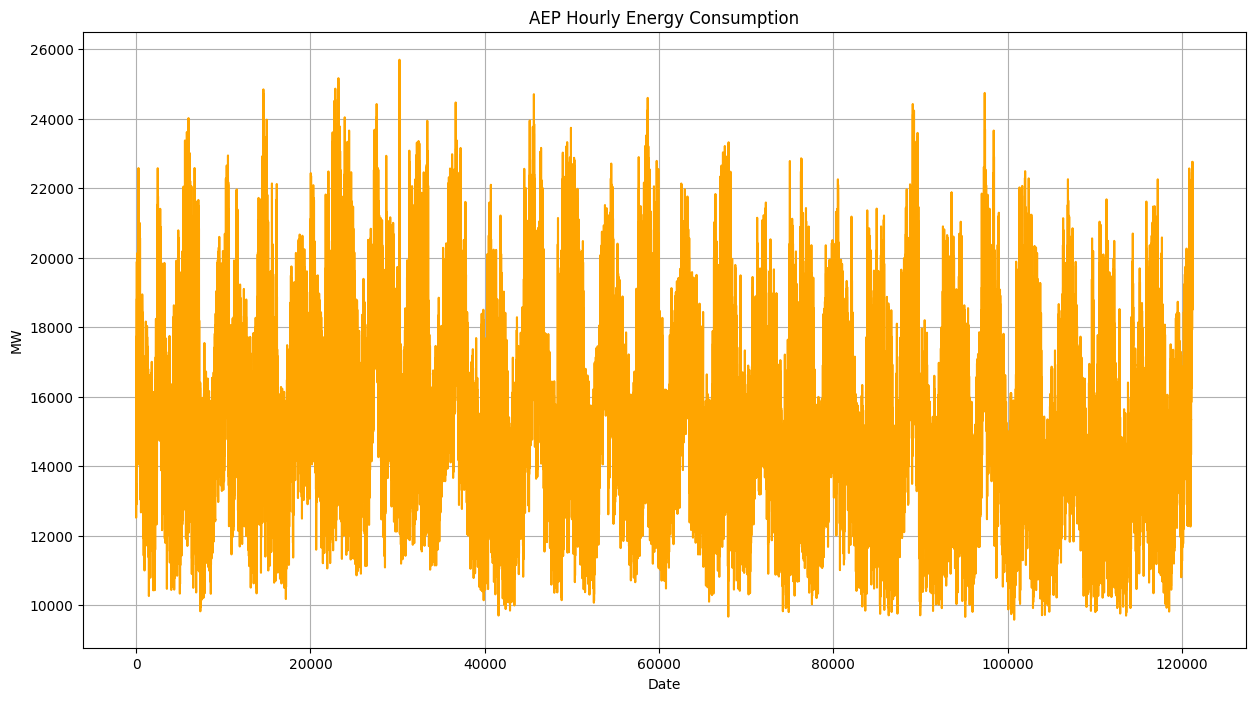

In [148]:
plt.figure(figsize=(15,8))
plot_series(AEP_hourly.index,
            AEP_hourly['AEP_MW'], xlabel='Date',
            ylabel='MW', title='AEP Hourly Energy Consumption')

In [149]:
start_time = AEP_hourly.index.dt.year = 2015
end_time = AEP_hourly.index.dt.year = 2017

start_time

AttributeError: 'RangeIndex' object has no attribute 'dt'

# Exploratory Data Analyst

In [ ]:
AEP_hourly.info()
